In [1]:
import math, random

import torch
import torch.nn as nn
from torch.nn import init, functional
from torch.utils.data import DataLoader, Dataset, random_split

import torchaudio
from torchaudio import transforms

from scipy.signal import filtfilt
from scipy import stats
import scipy

import torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinarySpecificity
from sklearn import metrics

import pandas as pd
import numpy as np
from IPython.display import Audio
from matplotlib import pyplot as plt
from os import walk

from packages.metrics_saver import update_metrics, get_metrics

In [2]:
#To allow plotting pytorch tensors
torch.Tensor.ndim = property(lambda self: len(self.shape))
#use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Audio Properties

In [4]:
MAX_AUDIO_LENGTH = 5000
SAMPLING_RATE = 2000
N_CHANNELS = 1
SHIFT_PCT = 0.2
FREQ_SHIFT_PCT = 0.1

LOW_FREQ = 15
HIGH_FREQ = 200
ORDER = 3

SPEC_HOP_LENGTH=64
SPEC_N_FFT=512   # standard number
SPEC_N_MELS=64  

MFCC_HOP_LENGTH=32
MFCC_N_FFT=512   # standard number
MFCC_N_MELS=64  
N_MFCC=13   # standard number

In [5]:
BATCH_SIZE = 64

# AudioUtils

In [6]:
class AudioUtil():
    @staticmethod
    def open(audio_file):

        #Open an audio file
        # print(f"Opening file : {audio_file}")
        sig, sr = torchaudio.load(audio_file)
        sig.to(device)
        return (sig, sr)
    
    @staticmethod
    def print(aud, channel):

        #Plot the audio signal wave

        sig, sr = aud
        duration = sig.shape[1]
        time = torch.linspace(0, duration/sr, duration)

        print(sig.shape)
        print('Plotting...')

        plt.figure(figsize=(15, 5))
        plt.plot(time, sig.cpu()[channel - 1])
        plt.title('Audio Plot')
        plt.ylabel(' signal wave')
        plt.xlabel('time (s)')
        plt.show()

    @staticmethod
    def display_spectrogram(spec, label='Audio mel spectrogram'):
        
        #Display the audio mel spectrogram

        print(spec.shape)
        print('Plotting...')
        
        plt.figure(figsize=(15,5))
        plt.imshow(spec[0], aspect='auto')
        plt.title(label)
        plt.ylabel('Frequency (mels)')
        plt.xlabel('Time (ms)')
        plt.colorbar(format='%+2.0f dB')

        plt.show()
    
    @staticmethod
    def display_MFCC(mfcc, label='Audio MFCCs', type='image'):
        
        #Display the audio MFCCs

        print(mfcc.shape)
        print('Plotting...')

        if(type == 'graph'):
            plt.figure(figsize=(15,5))
            # ([1, 13, 501])
            for i,d in enumerate(mfcc[0]):
                plt.plot(d, label='mfcc ' + str(i))
            plt.title(label)
            plt.ylabel('Amplitude')
            plt.xlabel('Time (ms)')
            plt.legend()
            plt.show()
            return
        
        plt.figure(figsize=(15,5))
        plt.imshow(mfcc[0], aspect='auto')
        plt.title(label)
        plt.ylabel('Index')
        plt.xlabel('Time (ms)')
        plt.colorbar(format='%+2.0f dB')

        plt.show()

    @staticmethod
    def rechannel(aud, new_channel):

        #Convert the audio from mono to stereo or vice versa

        sig, sr = aud

        if(sig.shape[0] == new_channel):
            return aud
        
        # print('Rechanneling to ' + str(new_channel))
        if(new_channel == 1):
            resig = sig[:1, :]
        else:
            resig = torch.cat([sig, sig])
        
        return ((resig, sr))

    @staticmethod
    def resample(aud, newsr):

        #Resample the audio to the newsr frequency

        sig, sr = aud
        
        if(sr == newsr):
            return((sig, sr))
        
        # print('Resampling to ' + str(newsr))

        num_channels = sig.shape[0]
        resig_fn = torchaudio.transforms.Resample(sr, newsr).to(device)
        resig = resig_fn(sig[:1, :].to(device))
        if(num_channels > 1):
            retwo_fn = torchaudio.transforms.Resample(sr, newsr).to(device)
            retwo = retwo_fn(sig[1:, :].to(device))
            resig = torch.cat([resig, retwo])

        return((resig, newsr))

    @staticmethod
    def butterworth_filter(aud, low_cutoff_freq=15, high_cutoff_freq=900, order=3):
        sig, sr = aud

        nyq = 0.5 * sr
        low = low_cutoff_freq / nyq
        high = high_cutoff_freq / nyq
        
        b, a = scipy.signal.butter(order, [low, high], 'bandpass', analog=False)
        filtered_sig = scipy.signal.filtfilt(b, a, sig.cpu(), axis=1)
        filtered_sig = torch.Tensor(filtered_sig.copy()).to(device)
        
        return ((filtered_sig, sr))

    @staticmethod
    def pad_trunc(aud, max_ms):
        #add padding, or truncate the signal to fit the max length
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if(sig_len > max_len):
            #Truncate the signal
            # print('Truncating signal to ' + str(max_ms) + ' ms')
            sig = sig[:, :max_len]
        elif(sig_len < max_len):
            #Add padding
            # print('Padding signal to ' + str(max_ms) + ' ms')
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            pad_begin = torch.zeros((num_rows, pad_begin_len)).to(device)
            pad_end = torch.zeros((num_rows, pad_end_len)).to(device)

            sig = torch.cat((pad_begin, sig, pad_end), 1)
        
        return ((sig, sr))

    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    @staticmethod
    def pitch_shift(aud, shift_limit):
        sig, sr = aud
        shift_amt = random.random() * shift_limit
        return (sig * shift_amt, sr)

    @staticmethod
    def get_mel_spectrogram(aud, hop_length=512, n_fft=1024, n_mels=64):
        sig, sr = aud
        top_db = 80

        mel_transformation = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        db_transformation = torchaudio.transforms.AmplitudeToDB(top_db=top_db)
        mel_transformation.to(device)
        db_transformation.to(device)
        spec = mel_transformation(sig.to(device))
        spec = db_transformation(spec.to(device))
        return spec

    @staticmethod
    def spectro_augment(spec, max_mask_pct = 0.1, n_freq_masks = 1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_max_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_max_param).to(device)(aug_spec, mask_value)
        time_mask_params = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_params).to(device)(aug_spec, mask_value)

        return aug_spec

    @staticmethod
    def get_MFCC(aud, hop_length=512, n_fft=1024, n_mels=64, n_mfcc = 64):
        sig, sr = aud
        mfcc_fn = transforms.MFCC(  sample_rate=sr,
                                    n_mfcc=n_mfcc,
                                    melkwargs={"n_fft": n_fft, "n_mels": n_mels, "hop_length": hop_length})
        mfcc_fn.to(device)
        return mfcc_fn(sig.to(device))
    
    @staticmethod
    def get_DeltaMFCC(mfcc):
        delta_fn = torchaudio.transforms.ComputeDeltas().to(device)
        delta_mfcc = delta_fn(mfcc)
        delta2_mfcc = delta_fn(delta_mfcc)

        return (delta_mfcc, delta2_mfcc)

    @staticmethod
    def preprocess_audio_only(audio_dir):
        aud = AudioUtil.open(audio_dir)
        aud = AudioUtil.rechannel(aud, N_CHANNELS)
        aud = AudioUtil.resample(aud, SAMPLING_RATE)
        aud = AudioUtil.pad_trunc(aud, MAX_AUDIO_LENGTH)
        aud = AudioUtil.time_shift(aud, SHIFT_PCT)
        aud = AudioUtil.pitch_shift(aud, FREQ_SHIFT_PCT)
        sig, sr = aud
        return sig
    @staticmethod
    def preprocess_audio(audio_dir):
        aud = AudioUtil.open(audio_dir)
        aud = AudioUtil.rechannel(aud, N_CHANNELS)
        aud = AudioUtil.resample(aud, SAMPLING_RATE)
        aud = AudioUtil.butterworth_filter(aud, LOW_FREQ, HIGH_FREQ, ORDER)
        aud = AudioUtil.pad_trunc(aud, MAX_AUDIO_LENGTH)
        aud = AudioUtil.time_shift(aud, SHIFT_PCT)
        aud = AudioUtil.pitch_shift(aud, SHIFT_PCT)
        spec = AudioUtil.get_mel_spectrogram(aud, hop_length=SPEC_HOP_LENGTH, n_fft=SPEC_N_FFT, n_mels=SPEC_N_MELS)
        aug_spec = AudioUtil.spectro_augment(spec, n_freq_masks=2, n_time_masks=2)
        mfcc = AudioUtil.get_MFCC(aud, hop_length=MFCC_HOP_LENGTH, n_fft=MFCC_N_FFT, n_mels=MFCC_N_MELS, n_mfcc=N_MFCC)
        mfcc_1, mfcc_2 = AudioUtil.get_DeltaMFCC(mfcc)
        return (aud, spec, aug_spec, mfcc, mfcc_1, mfcc_2)

# Visualize

torch.Size([1, 10000])
Plotting...


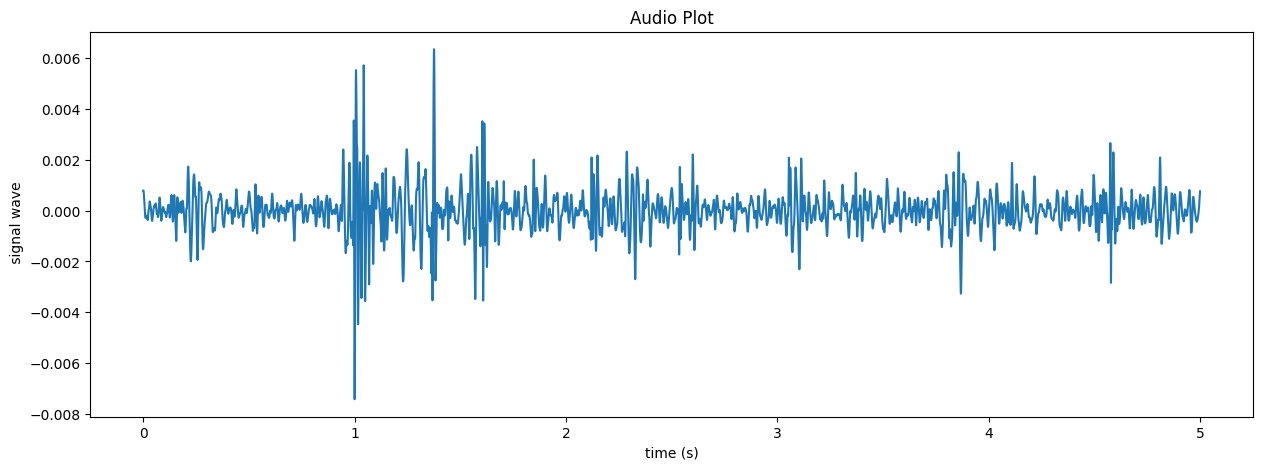

torch.Size([1, 64, 157])
Plotting...


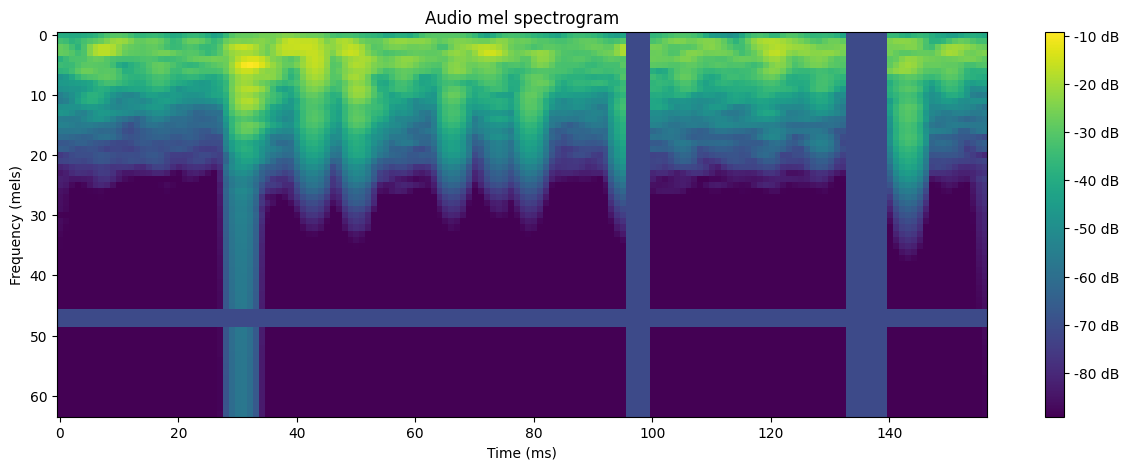

torch.Size([1, 13, 313])
Plotting...


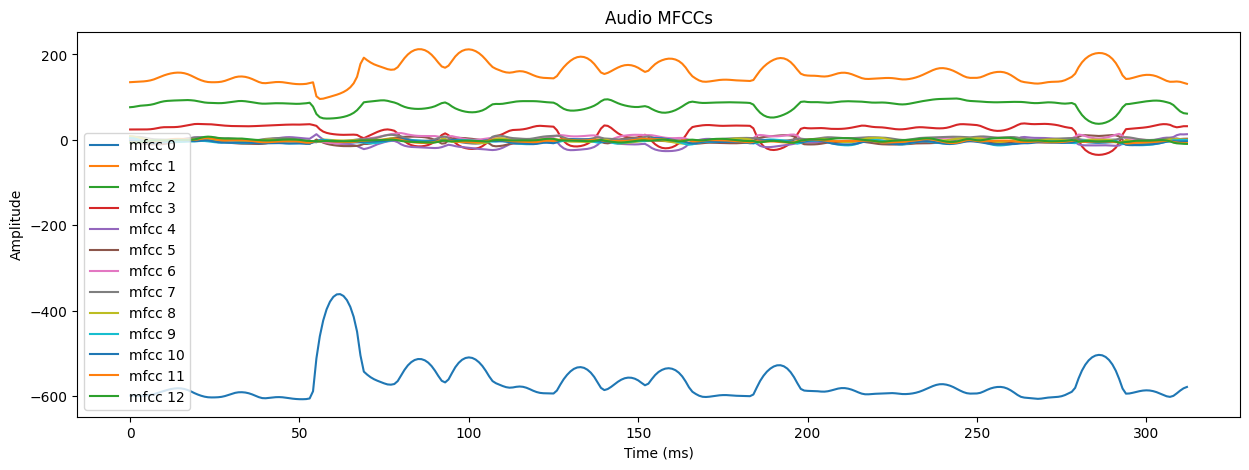

torch.Size([1, 13, 313])
Plotting...


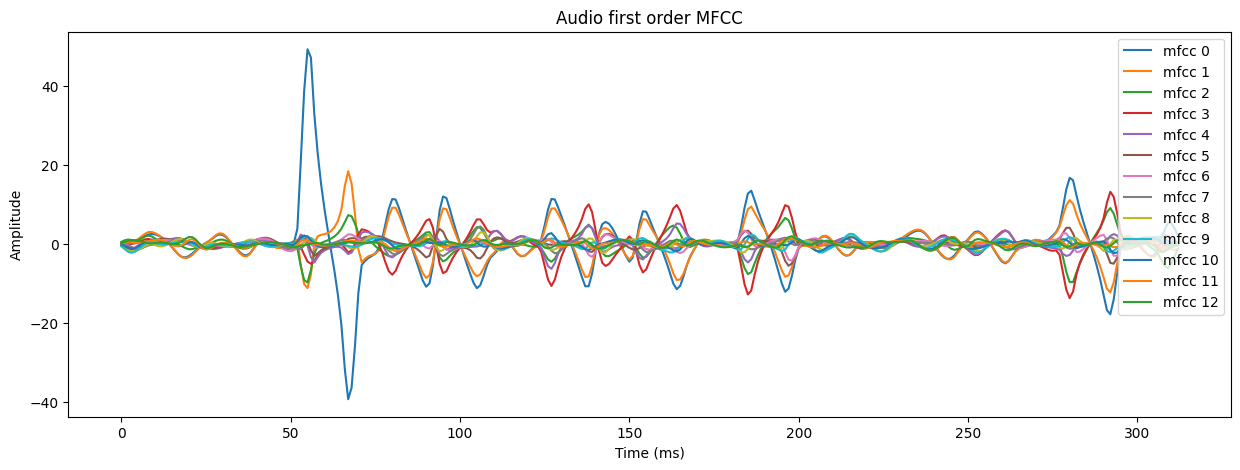

torch.Size([1, 13, 313])
Plotting...


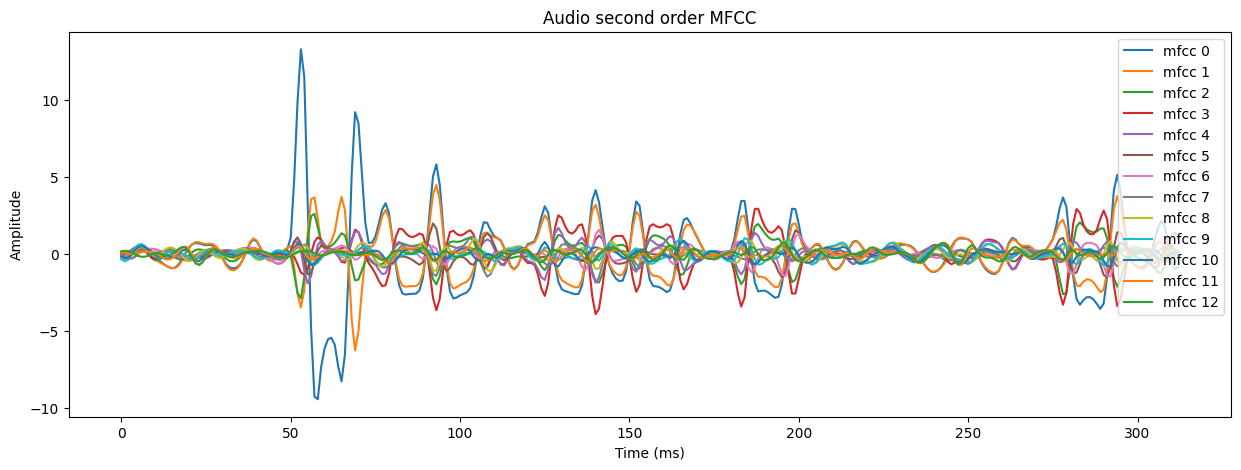

In [7]:
aud, _, aug_spec, mfcc, delta_mfcc, delta2_mfcc = AudioUtil.preprocess_audio('./Dataset/PhysioNet/validation/a0009.wav')

AudioUtil.print(aud, 1)
AudioUtil.display_spectrogram(aug_spec.cpu())
AudioUtil.display_MFCC(mfcc.cpu(), type='graph')
AudioUtil.display_MFCC(delta_mfcc.cpu(), label='Audio first order MFCC', type='graph')
AudioUtil.display_MFCC(delta2_mfcc.cpu(), label='Audio second order MFCC', type='graph')

# Import Dataset

In [8]:
from packages.physionet_importer import getTrainingSet, getValidationSet
df = getTrainingSet()

# Custom Sound Dataset

In [9]:
class SoundDS(Dataset):
    # constructor
    def __init__(self, _df, ret='spec', mode='cnn'):
        super().__init__()
        self.ret = ret
        self.mode = mode
        self.df = _df
    
    # get length of ds
    def __len__(self):
        return len(self.df)
    
    # get i'th item in dataset
    def __getitem__(self, idx):
        audio_file = self.df.loc[idx, 'relative_path']  # get audio file path
        class_id = self.df.loc[idx, 'classID']          # get class id

        aud = AudioUtil.open(audio_file)
        aud = AudioUtil.rechannel(aud, N_CHANNELS)
        aud = AudioUtil.resample(aud, SAMPLING_RATE)
        aud = AudioUtil.butterworth_filter(aud, LOW_FREQ, HIGH_FREQ, ORDER)
        aud = AudioUtil.pad_trunc(aud, MAX_AUDIO_LENGTH)
        aud = AudioUtil.time_shift(aud, SHIFT_PCT)
        aud = AudioUtil.pitch_shift(aud, SHIFT_PCT)
        spec = AudioUtil.get_mel_spectrogram(aud, hop_length=SPEC_HOP_LENGTH, n_fft=SPEC_N_FFT, n_mels=SPEC_N_MELS)
        aug_spec = AudioUtil.spectro_augment(spec, n_freq_masks=2, n_time_masks=2)
        
        return aug_spec, class_id

# Random Split

In [10]:
ds = SoundDS(df, ret='spec', mode='cnn')

num_items = len(ds)
num_train = round(num_items * 0.75) # 75 % training
num_val = round(num_items * 0.15) # 15 % validation
num_test = num_items - num_train - num_val # 10 % test

torch.manual_seed(torch.initial_seed())
train_ds, val_ds, test_ds = random_split(ds, [num_train, num_val, num_test], generator=torch.Generator().manual_seed(SEED))

# Saving Dataloader Object

In [17]:
train_df = pd.DataFrame(columns=['relative_path', 'classID'])
train_path = 'Dataset/PhysioNetPreprocessed' + '/train'
for i, (data, classID) in enumerate(train_ds):
    file_path = train_path + '/data_' + str(i) + '.pth'
    torch.save(data, file_path)
    train_df.loc[len(train_df)] = [file_path, classID]
print(train_df)
train_df.to_csv(train_path + '/REFERENCES.csv')

                                          relative_path  classID
0        Dataset/PhysioNetPreprocessed/train/data_0.pth        0
1        Dataset/PhysioNetPreprocessed/train/data_1.pth        0
2        Dataset/PhysioNetPreprocessed/train/data_2.pth        0
3        Dataset/PhysioNetPreprocessed/train/data_3.pth        0
4        Dataset/PhysioNetPreprocessed/train/data_4.pth        0
...                                                 ...      ...
2425  Dataset/PhysioNetPreprocessed/train/data_2425.pth        0
2426  Dataset/PhysioNetPreprocessed/train/data_2426.pth        0
2427  Dataset/PhysioNetPreprocessed/train/data_2427.pth        0
2428  Dataset/PhysioNetPreprocessed/train/data_2428.pth        0
2429  Dataset/PhysioNetPreprocessed/train/data_2429.pth        0

[2430 rows x 2 columns]


In [18]:
val_df = pd.DataFrame(columns=['relative_path', 'classID'])
val_path = 'Dataset/PhysioNetPreprocessed' + '/validation'
for i, (data, classID) in enumerate(val_ds):
    file_path = val_path + '/data_' + str(i) + '.pth'
    torch.save(data, file_path)
    val_df.loc[len(val_df)] = [file_path, classID]
print(val_df)
val_df.to_csv(val_path + '/REFERENCES.csv')

                                         relative_path  classID
0    Dataset/PhysioNetPreprocessed/validation/data_...        0
1    Dataset/PhysioNetPreprocessed/validation/data_...        0
2    Dataset/PhysioNetPreprocessed/validation/data_...        0
3    Dataset/PhysioNetPreprocessed/validation/data_...        0
4    Dataset/PhysioNetPreprocessed/validation/data_...        0
..                                                 ...      ...
481  Dataset/PhysioNetPreprocessed/validation/data_...        1
482  Dataset/PhysioNetPreprocessed/validation/data_...        0
483  Dataset/PhysioNetPreprocessed/validation/data_...        0
484  Dataset/PhysioNetPreprocessed/validation/data_...        0
485  Dataset/PhysioNetPreprocessed/validation/data_...        0

[486 rows x 2 columns]


In [16]:
test_df = pd.DataFrame(columns=['relative_path', 'classID'])
test_path = 'Dataset/PhysioNetPreprocessed' + '/test'
for i, (data, classID) in enumerate(test_ds):
    file_path = test_path + '/data_' + str(i) + '.pth'
    torch.save(data, file_path)
    test_df.loc[len(test_df)] = [file_path, classID]
print(test_df)
test_df.to_csv(test_path + '/REFERENCES.csv')

                                       relative_path  classID
0      Dataset/PhysioNetPreprocessed/test/data_0.pth        1
1      Dataset/PhysioNetPreprocessed/test/data_1.pth        0
2      Dataset/PhysioNetPreprocessed/test/data_2.pth        0
3      Dataset/PhysioNetPreprocessed/test/data_3.pth        0
4      Dataset/PhysioNetPreprocessed/test/data_4.pth        0
..                                               ...      ...
319  Dataset/PhysioNetPreprocessed/test/data_319.pth        0
320  Dataset/PhysioNetPreprocessed/test/data_320.pth        0
321  Dataset/PhysioNetPreprocessed/test/data_321.pth        0
322  Dataset/PhysioNetPreprocessed/test/data_322.pth        1
323  Dataset/PhysioNetPreprocessed/test/data_323.pth        0

[324 rows x 2 columns]
